In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/prediction-of-electric-power/submission.csv
/kaggle/input/prediction-of-electric-power/train_df.csv
/kaggle/input/prediction-of-electric-power/test_df.csv


In [6]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from datetime import datetime
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import lightgbm as lgb
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from scipy.spatial.distance import cdist
from sklearn.cluster import AgglomerativeClustering

import holidays
import warnings
warnings.filterwarnings('ignore')
#submission = pd.read_csv("/kaggle/input/prediction-of-electric-power/submission.csv")
#submission.head()

In [7]:
train_df = pd.read_csv("/kaggle/input/prediction-of-electric-power/train_df.csv")
test_df = pd.read_csv("/kaggle/input/prediction-of-electric-power/test_df.csv")
train_df.head()

,ID,DATE,V_1,V_2,V_3,V_4,V_5,V_6,V_7,V_8,V_9,V_10,V_11,V_12,V_13,SOT,LAT,LON,POWER
0,0,2019/8/20,0.464390,-2.844192,647.669067,303.707458,0.7557,98.452492,0.836825,89,0.350000,3,0.056600,2.058981,237.326815,2357A,28.0950,116.9622,31.083333
1,1,2019/12/12,0.353248,-0.269249,319.740570,278.104065,0.2426,102.246086,0.773377,40,32.419998,13,0.000266,2.604919,76.872996,1653A,35.4280,116.6305,61.250000
2,2,2019/4/7,0.217054,-3.203711,410.029419,295.771332,0.4007,95.362344,0.818272,366,30.200001,12,0.005800,2.404734,235.531159,2562A,30.1506,104.6356,26.083333
3,3,2019/12/2,0.332295,-1.231481,595.750732,285.615051,0.3063,101.249391,0.789055,90,45.349998,13,0.003160,0.060650,159.524072,1403A,22.8225,108.3210,23.458333
4,4,2019/7/14,0.462568,-1.437667,790.363586,304.423859,0.3450,96.466047,0.828973,377,25.780001,12,3.821720,2.643497,318.380560,2179A,35.1147,111.0414,29.541667


In [8]:
train_df.isnull().sum()

ID       0
DATE     0
V_1      0
V_2      0
V_3      0
V_4      0
V_5      0
V_6      0
V_7      0
V_8      0
V_9      0
V_10     0
V_11     0
V_12     0
V_13     0
SOT      0
LAT      0
LON      0
POWER    0
dtype: int64

<AxesSubplot: xlabel='V_4', ylabel='Count'>

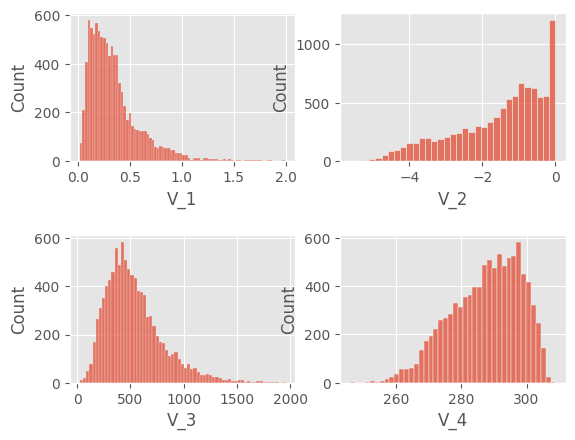

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

fig, ax = plt.subplots(2, 2)
plt.subplots_adjust(hspace=0.5)
sns.histplot(data=train_df, x="V_1", ax=ax[0,0])
sns.histplot(data=train_df, x="V_2", ax=ax[0,1])
sns.histplot(data=train_df, x="V_3", ax=ax[1,0])
sns.histplot(data=train_df, x="V_4", ax=ax[1,1])

<AxesSubplot: xlabel='V_8', ylabel='Count'>

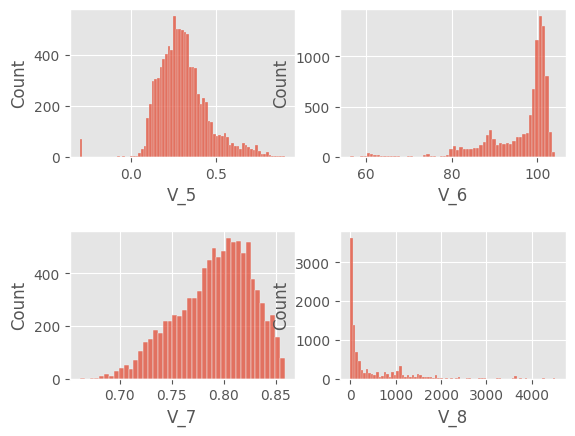

In [10]:
fig, ax = plt.subplots(2, 2)
plt.subplots_adjust(hspace=0.5)
sns.histplot(data=train_df, x="V_5", ax=ax[0,0])
sns.histplot(data=train_df, x="V_6", ax=ax[0,1])
sns.histplot(data=train_df, x="V_7", ax=ax[1,0])
sns.histplot(data=train_df, x="V_8", ax=ax[1,1])

<AxesSubplot: xlabel='V_12', ylabel='Count'>

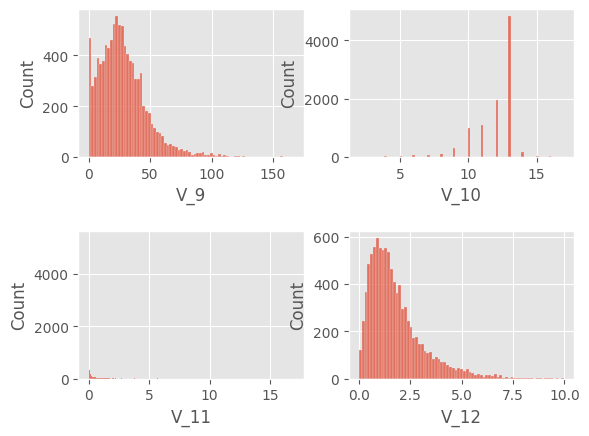

In [11]:
fig, ax = plt.subplots(2, 2)
plt.subplots_adjust(hspace=0.5)
sns.histplot(data=train_df, x="V_9", ax=ax[0,0])
sns.histplot(data=train_df, x="V_10", ax=ax[0,1])
sns.histplot(data=train_df, x="V_11", ax=ax[1,0])
sns.histplot(data=train_df, x="V_12", ax=ax[1,1])

<AxesSubplot: xlabel='LON', ylabel='Count'>

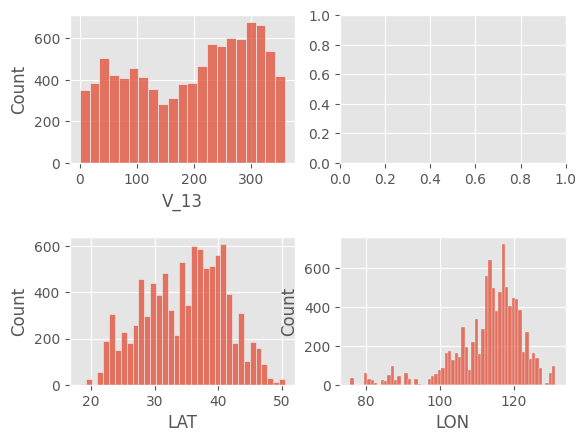

In [12]:
fig, ax = plt.subplots(2, 2)
plt.subplots_adjust(hspace=0.5)
sns.histplot(data=train_df, x="V_13", ax=ax[0,0])
#sns.histplot(data=train_df, x="SOT", ax=ax[0,1])
sns.histplot(data=train_df, x="LAT", ax=ax[1,0])
sns.histplot(data=train_df, x="LON", ax=ax[1,1])

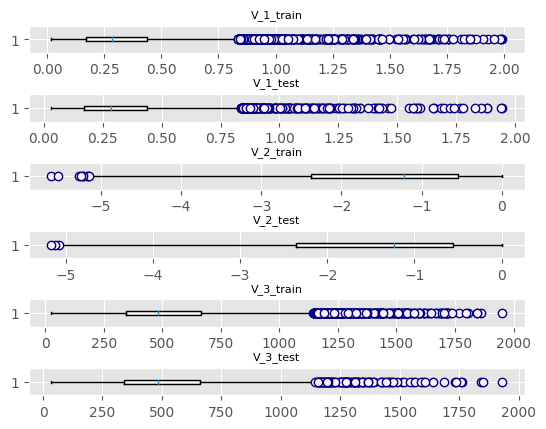

In [13]:
fig, axes = plt.subplots(6, 1)
plt.subplots_adjust(hspace=1.5)

flierprops = dict(marker='o',markerfacecolor='#FFF0F5',markersize=6, markeredgecolor='navy')

_ = axes[0].boxplot(x=train_df.V_1, flierprops=flierprops, vert=False, whis=1.5)
_ = axes[1].boxplot(x=test_df.V_1, flierprops=flierprops, vert=False, whis=1.5)

_ = axes[0].set_title('V_1_train', fontdict={'fontsize': 8})
_ = axes[1].set_title('V_1_test', fontdict={'fontsize': 8})

flierprops = dict(marker='o', markerfacecolor='#FFF0F5', markersize=6, markeredgecolor='navy')

_ = axes[2].boxplot(x=train_df.V_2, flierprops=flierprops, vert=False, whis=1.5)
_ = axes[3].boxplot(x=test_df.V_2, flierprops=flierprops, vert=False, whis=1.5)

_ = axes[2].set_title('V_2_train', fontdict={'fontsize': 8})
_ = axes[3].set_title('V_2_test', fontdict={'fontsize': 8})

flierprops = dict(marker='o', markerfacecolor='#FFF0F5', markersize=6, markeredgecolor='navy')

_ = axes[4].boxplot(x=train_df.V_3, flierprops=flierprops, vert=False, whis=1.5)
_ = axes[5].boxplot(x=test_df.V_3, flierprops=flierprops, vert=False, whis=1.5)

_ = axes[4].set_title('V_3_train', fontdict={'fontsize': 8})
_ = axes[5].set_title('V_3_test', fontdict={'fontsize': 8})

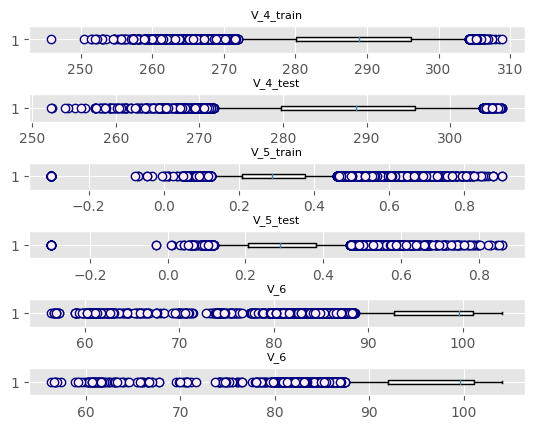

In [14]:
fig, axes = plt.subplots(6, 1)
plt.subplots_adjust(hspace=1.5)

flierprops = dict(marker='o', markerfacecolor='#FFF0F5', markersize=6, markeredgecolor='navy')

_ = axes[0].boxplot(x=train_df.V_4, flierprops=flierprops, vert=False, whis=0.5)
_ = axes[1].boxplot(x=test_df.V_4, flierprops=flierprops, vert=False, whis=0.5)

_ = axes[0].set_title('V_4_train', fontdict={'fontsize': 8})
_ = axes[1].set_title('V_4_test', fontdict={'fontsize': 8})

flierprops = dict(marker='o', markerfacecolor='#FFF0F5', markersize=6, markeredgecolor='navy')

_ = axes[2].boxplot(x=train_df.V_5, flierprops=flierprops, vert=False, whis=0.5)
_ = axes[3].boxplot(x=test_df.V_5, flierprops=flierprops, vert=False, whis=0.5)

_ = axes[2].set_title('V_5_train', fontdict={'fontsize': 8})
_ = axes[3].set_title('V_5_test', fontdict={'fontsize': 8})

flierprops = dict(marker='o', markerfacecolor='#FFF0F5', markersize=6, markeredgecolor='navy')

_ = axes[4].boxplot(x=train_df.V_6, flierprops=flierprops, vert=False, whis=0.5)
_ = axes[5].boxplot(x=test_df.V_6, flierprops=flierprops, vert=False, whis=0.5)

_ = axes[4].set_title('V_6', fontdict={'fontsize': 8})
_ = axes[5].set_title('V_6', fontdict={'fontsize': 8})

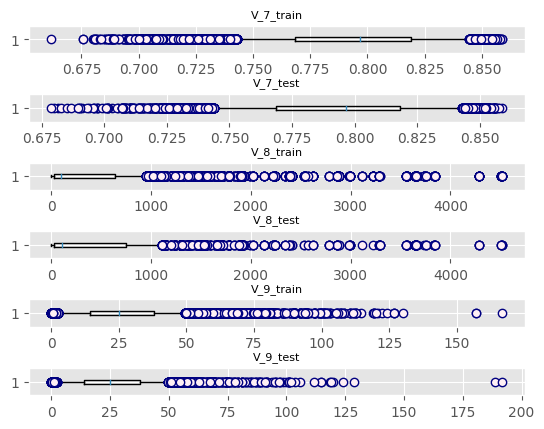

In [15]:
fig, axes = plt.subplots(6, 1)
plt.subplots_adjust(hspace=1.5)

flierprops = dict(marker='o', markerfacecolor='#FFF0F5', markersize=6, markeredgecolor='navy')

_ = axes[0].boxplot(x=train_df.V_7, flierprops=flierprops, vert=False, whis=0.5)
_ = axes[1].boxplot(x=test_df.V_7, flierprops=flierprops, vert=False, whis=0.5)

_ = axes[0].set_title('V_7_train', fontdict={'fontsize': 8})
_ = axes[1].set_title('V_7_test', fontdict={'fontsize': 8})

flierprops = dict(marker='o', markerfacecolor='#FFF0F5', markersize=6, markeredgecolor='navy')

_ = axes[2].boxplot(x=train_df.V_8, flierprops=flierprops, vert=False, whis=0.5)
_ = axes[3].boxplot(x=test_df.V_8, flierprops=flierprops, vert=False, whis=0.5)

_ = axes[2].set_title('V_8_train', fontdict={'fontsize': 8})
_ = axes[3].set_title('V_8_test', fontdict={'fontsize': 8})

flierprops = dict(marker='o', markerfacecolor='#FFF0F5', markersize=6, markeredgecolor='navy')

_ = axes[4].boxplot(x=train_df.V_9, flierprops=flierprops, vert=False, whis=0.5)
_ = axes[5].boxplot(x=test_df.V_9, flierprops=flierprops, vert=False, whis=0.5)

_ = axes[4].set_title('V_9_train', fontdict={'fontsize': 8})
_ = axes[5].set_title('V_9_test', fontdict={'fontsize': 8})

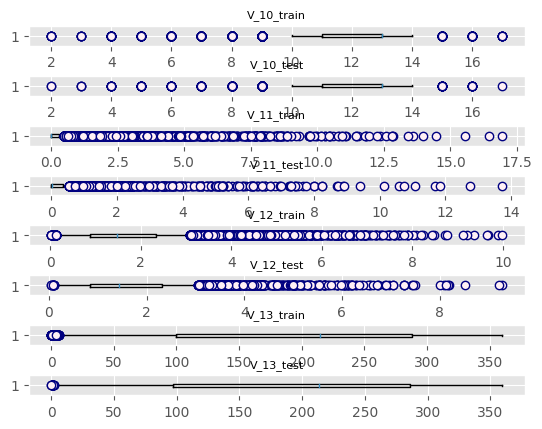

In [16]:
fig, axes = plt.subplots(8, 1)
plt.subplots_adjust(hspace=1.5)

flierprops = dict(marker='o', markerfacecolor='#FFF0F5', markersize=6, markeredgecolor='navy')

_ = axes[0].boxplot(x=train_df.V_10, flierprops=flierprops, vert=False, whis=0.5)
_ = axes[1].boxplot(x=test_df.V_10, flierprops=flierprops, vert=False, whis=0.5)

_ = axes[0].set_title('V_10_train', fontdict={'fontsize': 8})
_ = axes[1].set_title('V_10_test', fontdict={'fontsize': 8})

flierprops = dict(marker='o', markerfacecolor='#FFF0F5', markersize=6, markeredgecolor='navy')

_ = axes[2].boxplot(x=train_df.V_11, flierprops=flierprops, vert=False, whis=0.5)
_ = axes[3].boxplot(x=test_df.V_11, flierprops=flierprops, vert=False, whis=0.5)

_ = axes[2].set_title('V_11_train', fontdict={'fontsize': 8})
_ = axes[3].set_title('V_11_test', fontdict={'fontsize': 8})

flierprops = dict(marker='o', markerfacecolor='#FFF0F5', markersize=6, markeredgecolor='navy')

_ = axes[4].boxplot(x=train_df.V_12, flierprops=flierprops, vert=False, whis=0.5)
_ = axes[5].boxplot(x=test_df.V_12, flierprops=flierprops, vert=False, whis=0.5)

_ = axes[4].set_title('V_12_train', fontdict={'fontsize': 8})
_ = axes[5].set_title('V_12_test', fontdict={'fontsize': 8})

flierprops = dict(marker='o', markerfacecolor='#FFF0F5', markersize=6, markeredgecolor='navy')

_ = axes[6].boxplot(x=train_df.V_13, flierprops=flierprops, vert=False, whis=0.5)
_ = axes[7].boxplot(x=test_df.V_13, flierprops=flierprops, vert=False, whis=0.5)

_ = axes[6].set_title('V_13_train', fontdict={'fontsize': 8})
_ = axes[7].set_title('V_13_test', fontdict={'fontsize': 8})

In [17]:
train_df = train_df[train_df['V_2'] > -6]
train_df = train_df[train_df['V_4'] > 250]
#train_df = train_df[train_df['V_5'] > -0.2] bu aykırı değerleri çıkarmayacağım çünkü test verisinde de benzeri var
train_df = train_df[train_df['V_7'] > 0.675]
train_df = train_df[train_df['V_11'] < 14]
train_df = train_df[train_df['V_12'] < 9]

In [18]:
# mevsime göre elektirik harccaması değişicektir bu yüzden mevsimler sütunu işime yarayacaktır.

# train için
date=train_df['DATE'].values
isweekday=[]
for i in range(len(date)):
    isweekday.append(int(datetime.strptime(date[i],'%Y/%m/%d').weekday()<5))
spring=[0 for i in range(len(date))]
summer=[0 for i in range(len(date))]
fall=[0 for i in range(len(date))]
winter=[0 for i in range(len(date))]
for i in range(len(date)):
    month=int(date[i].split("/")[1])
    if 2<month<6:#3,4,5
        spring[i]=1
    elif 5<month<9:#6,7,8
        summer[i]=1
    elif 8<month<12:#9,10,11
        fall[i]=1
    else:#12,1,2
        winter[i]=1   
train_df['spring']=spring
train_df['summer']=summer
train_df['fall']=fall
train_df['winter']=winter

# test için
date=test_df['DATE'].values
isweekday=[]
for i in range(len(date)):
    isweekday.append(int(datetime.strptime(date[i],'%Y/%m/%d').weekday()<5))
spring=[0 for i in range(len(date))]
summer=[0 for i in range(len(date))]
fall=[0 for i in range(len(date))]
winter=[0 for i in range(len(date))]
for i in range(len(date)):
    month=int(date[i].split("/")[1])
    if 2<month<6:#3,4,5
        spring[i]=1
    elif 5<month<9:#6,7,8
        summer[i]=1
    elif 8<month<12:#9,10,11
        fall[i]=1
    else:#12,1,2
        winter[i]=1   
test_df['spring']=spring
test_df['summer']=summer
test_df['fall']=fall
test_df['winter']=winter


In [19]:
# tarih verisinin tipini datetime yap
train_df['DATE'] = pd.to_datetime(train_df['DATE'])
test_df['DATE'] = pd.to_datetime(test_df['DATE'])

In [20]:
# gün verilerinin ayarlanması

train_df['year'] = train_df['DATE'].dt.year 
train_df['month'] = train_df['DATE'].dt.month 
train_df['day'] = train_df['DATE'].dt.day
train_df['weekday'] = train_df['DATE'].dt.weekday+1
# np.where istenilen koşulu sağlayana ve sağlamayana verilecek değerleri vermeyi sağlar
train_df['Monday'] = np.where(train_df['weekday']==1,1,0) 
train_df['Tuesday'] = np.where(train_df['weekday']==2,1,0)
train_df['Wednesday'] = np.where(train_df['weekday']==3,1,0)
train_df['Thursday'] = np.where(train_df['weekday']==4,1,0)
train_df['Friday'] = np.where(train_df['weekday']==5,1,0)
train_df['weekofyear'] = train_df['DATE'].dt.weekofyear

test_df['year'] = test_df['DATE'].dt.year 
test_df['month'] = test_df['DATE'].dt.month 
test_df['day'] = test_df['DATE'].dt.day
test_df['weekday'] = test_df['DATE'].dt.weekday+1
test_df['Monday'] = np.where(test_df['weekday']==1,1,0) 
test_df['Tuesday'] = np.where(test_df['weekday']==2,1,0)
test_df['Wednesday'] = np.where(test_df['weekday']==3,1,0)
test_df['Thursday'] = np.where(test_df['weekday']==4,1,0)
test_df['Friday'] = np.where(test_df['weekday']==5,1,0)
test_df['weekofyear'] = test_df['DATE'].dt.weekofyear

In [21]:
# deney kısmı

#df['V1_2_6'] = df['V_1']+df['V_2']+df['V_6']
# df['V3_4_5_8'] = df['V_3']+df['V_4']+df['V_5']+df['V_8']
#df['V3_4_5'] = df['V_3']+df['V_4']+df['V_5']

#df['1_/_V_1'] = df['V_1'].apply(lambda x: 1/(x + 1e-3))
#df['V_1_square_2'] = df['V_1'].apply(lambda x: x**2)

In [22]:
# pipeline yi iyice araştır (projeyle alaksı yok unutmayayım diye)

train_df['POWER'] = np.log1p(train_df['POWER'])

In [23]:
len(train_df['SOT'].unique()) # kullansam mı kullanmasam mı bilemedim

1452

In [24]:
train_df.drop(['SOT','year'], axis=1, inplace=True)
test_df.drop(['SOT','year'], axis=1, inplace=True)

In [25]:
y_train = train_df['POWER']

x_train = train_df.drop(['ID', 'POWER', 'DATE'], axis=1)

x_test = test_df.drop(['ID', 'DATE'], axis=1)

category_list = train_df.columns[train_df.dtypes=='object'].values.tolist()

In [26]:
# LightGBM hiperparametrelerini ayarlama
lgbm_params = {
    'boosting_type': 'gbdt',        # Gradient Boosting Decision Tree
    'objective': 'regression',      # gerileme görevi
    'metric': 'rmse',               # değerlendirme indeksi
#     'max_depth': 8,
#     'learning_rate': 0.05,
    'learning_rate': 0.02,   # Varsayılan 0,1'dir, ancak biraz büyük görünür, bu nedenle veri sayısı on binlerce olduğunda genellikle 0,02 ila 0,05 olarak ayarlanır.
    'n_estimators': 100000,         # Erken Durdurma kullanıldığı için, büyük bir değere ayarlayın.
    'importance_type': 'gain',      # Özelliklerin önemini elde etmek için. Kazancı seçmenin daha iyi olduğu söylenir.
    
    # -- Model öğrenimini hızlandırın -- Daha büyük yaparsanız, daha fazlasını öğrenir, ancak üst üste takmak daha kolay olur.
#     'num_leaves': 31,               # 8〜256
    'num_leaves': 34,               # 8〜256
    
    
    # -- Model fazla uydurmanın önlenmesi -- # Boyutu artırarak fazla uydurmayı önleyebilirsiniz.
#     'min_data_in_leaf': 20,         # 5〜200
    'min_data_in_leaf': 13,         # 5〜200
    'min_sum_hessian_in_leaf': 20,  # 5〜200
#     'lambda_l1': 0.0,               # 0.01〜100
#     'lambda_l2': 0.0,               # 0.01〜100
    
    'lambda_l1': 0.05,               # 0.01〜100
    'lambda_l2': 0.05,               # 0.01〜100
    
#     'bagging_fraction': 1.0,        # Ne kadar küçük olursa, fazla uydurma o kadar bastırılır ve öğrenme hızı artar.
#     'bagging_freq': 1,              # 1'e ayarlandığında, örnekleme her karar ağacı oluşturulduğunda gerçekleştirilir. (varsayılan 0'dır)
#     'feature_fraction': 1.0,        # Ne kadar küçük olursa, fazla uydurma o kadar bastırılır ve öğrenme hızı artar.

    'bagging_fraction': 0.96,        # Ne kadar küçük olursa, fazla uydurma o kadar bastırılır ve öğrenme hızı artar.
    'bagging_freq': 1,              # 1'e ayarlandığında, örnekleme her karar ağacı oluşturulduğunda gerçekleştirilir. (varsayılan 0'dır)
    'feature_fraction': 0.96,        # Ne kadar küçük olursa, fazla uydurma o kadar bastırılır ve öğrenme hızı artar.
    
    'random_seed': 42               # Rastgele sayı ayarı. Rakamları kullanmaktan çekinmeyin.
}

[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] bagging_fraction is set=0.96, subsample=1.0 will be ignored. Current value: bagging_fraction=0.96
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05
[LightGBM] [Warning] feature_fraction is set=0.96, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.96
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=20, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[500]	training's rmse: 0.280827	valid_1's rmse: 0.353001
[1000]	training's rmse: 0.218117	valid_1's rmse: 0.3414
[1500]	training's rmse: 0.176742	valid_1's rmse: 0.336318
[2000

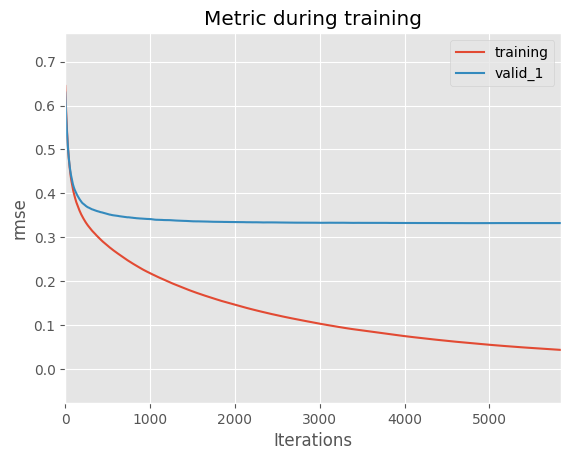

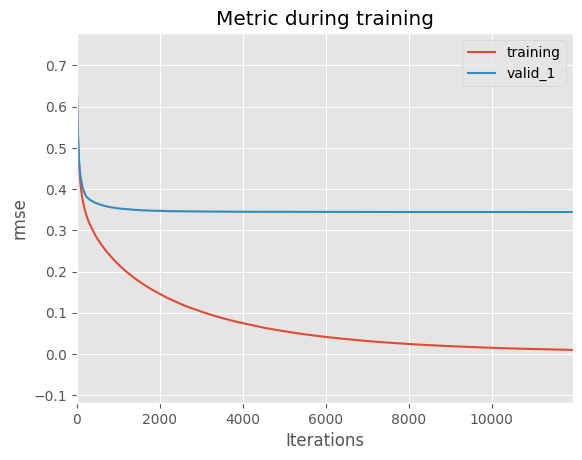

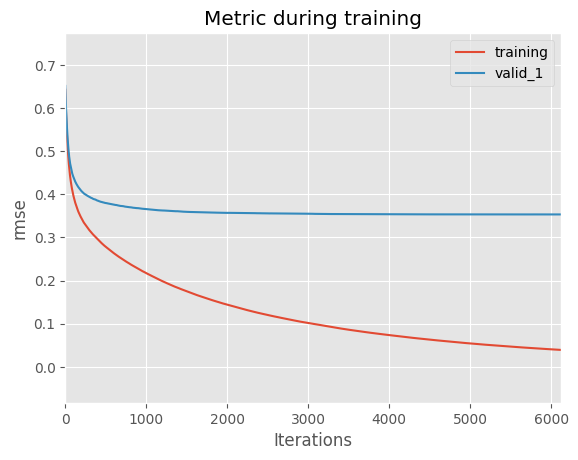

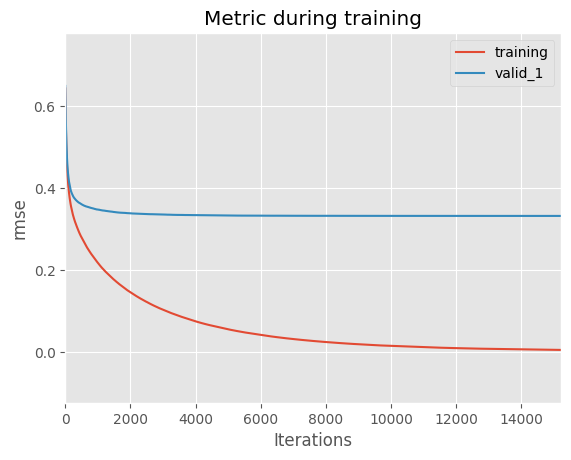

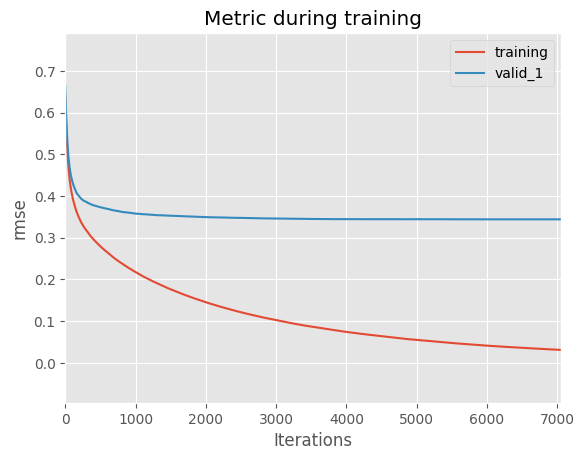

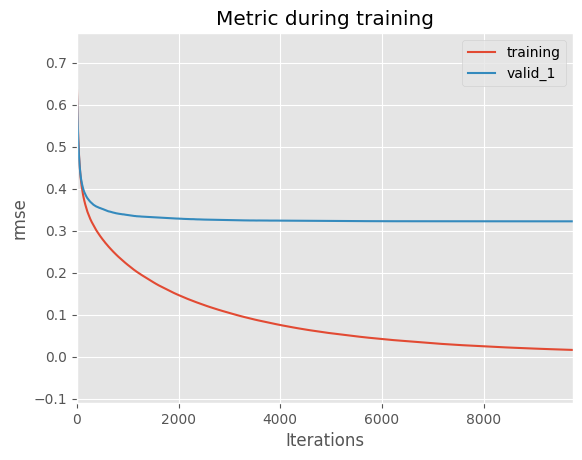

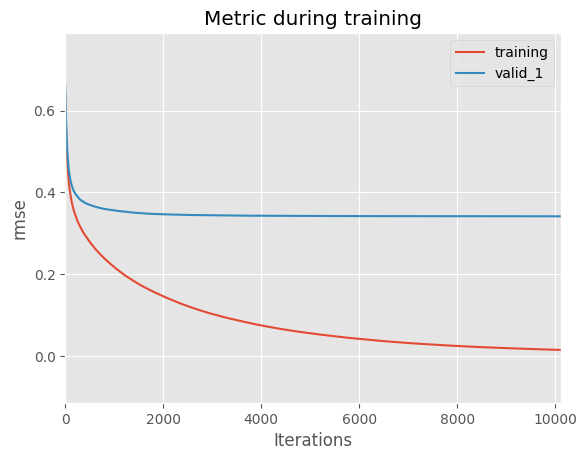

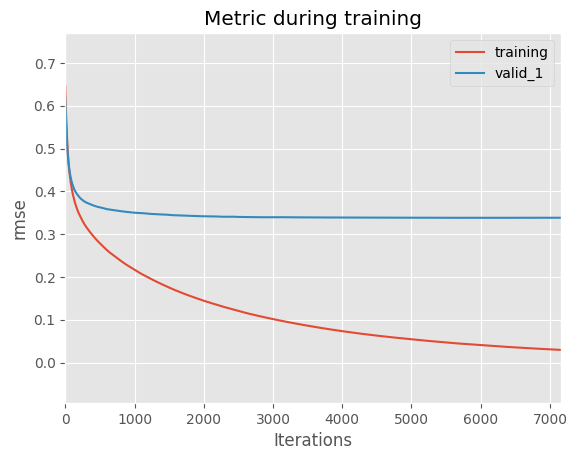

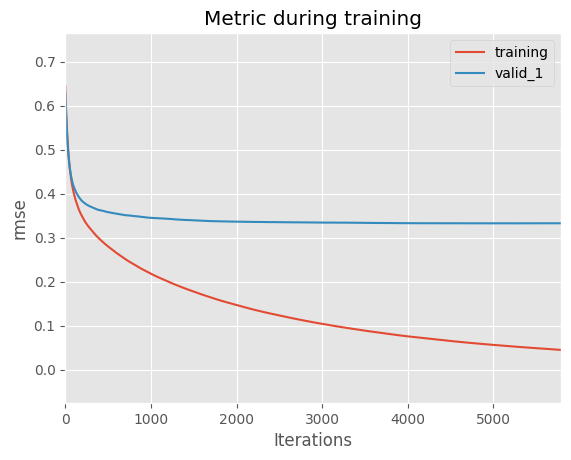

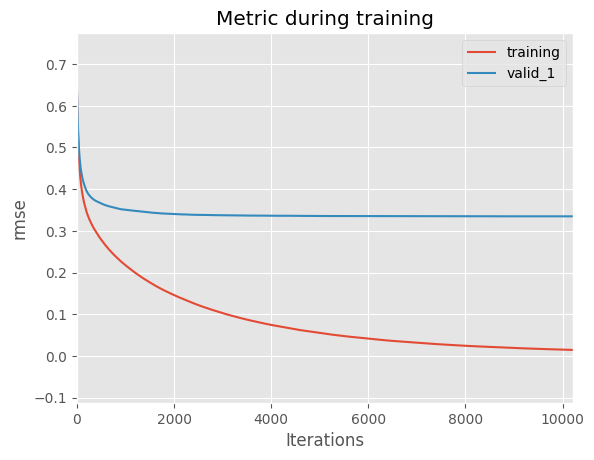

In [27]:
# CV katlama sayısını ayarlayın
# folds = 5
folds = 10
# Her özgeçmiş için eğitilmiş modelleri saklamak için bir liste hazırlayın
models = []

# Her CV için RMSE'yi saklamak üzere bir liste hazırlayın
rmses = []

# Doğrulama verilerinin tahminlerini depolamak için bir NumPy dizisi hazırlayın
out_of_fold = np.zeros(len(x_train))

# Açıklayıcı değişkenlerin önemini düzenleyen bir DF hazırlayın
imp_df = pd.DataFrame()


# ーーーー topluluk için ekle ーーーー
# true(Doğru cevap etiketi)depolayan bir NumPy dizisi
out_of_fold_true = np.zeros(len(x_train))

# Doğrulama dizinini saklamak için bir liste hazırlayın
valid_index_list = []
# ーーーーーーーーーーーーーーーーーーーー


# KFold nesnesi oluştur
kf = KFold(n_splits=folds, shuffle=True, random_state=42)        # Random_state sayısı serbesttir.


# KFold CV
for train_index, valid_index in kf.split(x_train):
    
    # Eğitim verilerinin açıklayıcı değişkenleri
    x_train_cv = x_train.iloc[train_index]
    
    # Eğitim verilerinin amaç değişkeni
    y_train_cv = y_train.iloc[train_index]
    
    # Doğrulama verileri için açıklayıcı değişkenler
    x_valid_cv = x_train.iloc[valid_index]
    
    # Doğrulama verilerinin nesnel değişkeni
    y_valid_cv = y_train.iloc[valid_index]
    
    # LightGBM model nesneleri oluşturuluyor
    model = lgb.LGBMRegressor(**lgbm_params)
    
    
    # modeli uydurma
    model.fit(
        x_train_cv, 
        y_train_cv, 
        eval_set = [(x_train_cv, y_train_cv), (x_valid_cv, y_valid_cv)], 
#         early_stopping_rounds = 100, 
        early_stopping_rounds = 1000, 
        categorical_feature = category_list, 
        verbose = 500, 
    )
    
    # eğitim verileriyle tahmin
    y_pred_train = model.predict(x_train_cv, num_iteration=model.best_iteration_)        # num_iteration=model.best_iteration_　で、Early-Stopping Şuna göre en uygun yinelemeyi elde edin:
    
    # doğrulama verileriyle tahmin
    y_pred_valid = model.predict(x_valid_cv, num_iteration=model.best_iteration_)        # num_iteration=model.best_iteration_　で、Early-Stopping Şuna göre en uygun yinelemeyi elde edin:
    
    # RMSE'yi hesapla
    # Eğitim verileri
    temp_rmse_train = np.sqrt(mean_squared_error(y_train_cv, y_pred_train))
    
    # Doğrulama verileri
    temp_rmse_valid = np.sqrt(mean_squared_error(y_valid_cv, y_pred_valid))
    
    # RMSE'nin görüntülenmesi
    print(f'\nRMSE(train_data) = {temp_rmse_train:.4f}')
    print(f'RMSE(valid_data) = {temp_rmse_valid:.4f}\n')
    
    # RMSE'yi listeye ekle
    rmses.append([temp_rmse_train, temp_rmse_valid])
    
    
    # eğitimli model ekleme
    models.append(model)
    
    # Tahmini doğrulama verileriyle değiştirin
    out_of_fold[valid_index] = y_pred_valid
    
    # ーーーー topluluk için ekle ーーーー
    # Doğrulama için doğru etiketi değiştirin
    out_of_fold_true[valid_index] = y_valid_cv
    
    # doğrulama dizini ekle
    valid_index_list.extend(valid_index)
    # ーーーーーーーーーーーーーーーーーーーー
    
    
    # Her CV için açıklayıcı değişkenlerin önemini bir DataFrame'e dönüştürün
    temp_imp = pd.DataFrame({
        'col': x_train.columns, 
        'imp': model.feature_importances_
    })
    
    # Önemli DataFrame'e katılın
    imp_df = pd.concat(
        [imp_df, temp_imp], 
        axis=0, 
        ignore_index=True
    )
    
    
    # Bir öğrenme eğrisi çizme
    lgb.plot_metric(model);

In [28]:
# NumPy rmses dizilimi
rmses_np = np.array(rmses)

# Eğitim verileri tahmini için ortalama RMSE
rmse_train_mean = rmses_np[:, 0].mean()
print(f'RMSE(train_data)_mean = {rmse_train_mean:.4f}')

# Doğrulama verilerinde tahmin için ortalama RMSE
rmse_valid_mean = rmses_np[:, 1].mean()
print(f'RMSE(valid_data)_mean = {rmse_valid_mean:.4f}')

RMSE(train_data)_mean = 0.0325
RMSE(valid_data)_mean = 0.3375


In [29]:
# Verileri test etmek için uygulama

# Her CV için eğitilen modelin tahmin sonuçlarını saklayan bir liste
preds_test = []


# Her CV için eğitilmiş modelle tahmin yürütün
for model in models:
    
    # predict
#     pred = np.expm1(model.predict(x_test, num_iteration=model.best_iteration_))
    pred = model.predict(x_test, num_iteration=model.best_iteration_)
    
    # sonucu listeye ekle
    preds_test.append(pred)

In [30]:
# Açıklayıcı değişkenlerin önemini şekillendirmek
imp_group_df = imp_df.groupby('col')['imp'].agg(['mean', 'std'])

# Sütun adını değiştir
imp_group_df.columns = ['imp_mean', 'imp_std']

# dizini sıfırla
imp_group_df = imp_group_df.reset_index(drop=False)

# imp_mean'e göre sırala
imp_group_df.sort_values('imp_mean', ascending=False, ignore_index=True).loc[0:20, :]

,col,imp_mean,imp_std
0,V_1,23435.052161,147.519504
1,V_3,9525.494755,195.371999
2,V_2,6603.364674,233.629110
3,weekofyear,5858.885166,205.842436
4,LAT,5612.845194,138.003151
5,V_7,5246.103205,255.900535
6,V_4,3989.613647,152.442889
7,LON,3819.162864,148.066835
8,V_6,3798.404458,217.365407
9,V_8,3670.686631,193.491099


In [31]:
# preds_test listesini NumPy dizisine dönüştür
preds_test_np = np.array(preds_test)

# ortalama almak
preds_test_np_mean = preds_test_np.mean(axis=0)

# çıktı
preds_test_np_mean

array([4.06008877, 3.32643107, 3.40343097, ..., 3.4349513 , 2.79404194,
       3.03919179])

In [32]:
test_df['POWER'] = preds_test_np_mean
power = train_df.pop('POWER')
train_df['POWER'] = power

power = test_df.pop('POWER')
test_df['POWER'] = power

df_all = pd.concat([train_df, test_df])

In [33]:
# Eğitim verileri için hedef değişkeni hazırlayın
y_train = df_all['POWER']

# Eğitim verileri için açıklayıcı değişkenler hazırlayın
x_train = df_all.drop(['ID', 'POWER', 'DATE'], axis=1)